## ENV SETUP

1. Install uv (or do it you're own way)
2. Run `uv sync`
3. Run `source .venv/bin/activate`

You're good to go.

# Instructions

The Task : Create the best CadQuery code generator model. 

1. Load the dataset (147K pairs of Images/CadQuery code).
2. Create a baseline model and evaluate it with the given metrics.
3. Enhance by any manner the baseline model and evaluate it again.
4. Explain you choices and possible bottlenecks. 
5. Show what enhancements you would have done if you had more time.

You can do *WHATEVER* you want, be creative, result is not what matters the most. 
Creating new model architectures, reusing ones you used in the past, fine-tuning, etc...

If you are GPU poor, there are solutions. Absolute value is not what matters, relative value between baseline and enhanced model is what matters.

My Solution : 

Step 0 : Installing Necessary librairies 

In [8]:
%pip install datasets transformers torchvision matplotlib pillow huggingface_hub[hf_xet]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Step 1 : Loading and Viewing data

Available keys in the sample: dict_keys(['image', 'deepcad_id', 'cadquery', 'token_count', 'prompt', 'hundred_subset'])


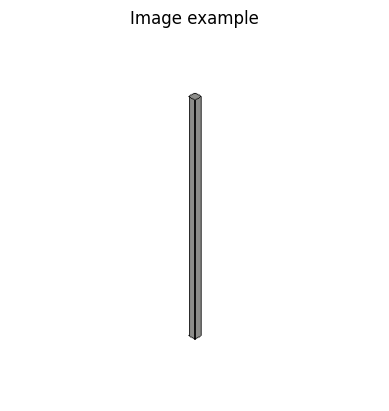

The key 'code' is not available in this sample.


In [9]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load the dataset (train/test split)
ds = load_dataset("CADCODER/GenCAD-Code", num_proc=16, split=["train", "test"], cache_dir="/Volumes/BIG-DATA/HUGGINGFACE_CACHE")

# Take one sample from the train set
sample = ds[0][0]  # ds[0] is 'train', ds[1] is 'test'

# Print available keys in the sample
print("Available keys in the sample:", sample.keys())

# Display the image if present
if "image" in sample:
    plt.imshow(sample["image"])
    plt.axis("off")
    plt.title("Image example")
    plt.show()
else:
    print("The key 'image' is not available in this sample.")

# Print the associated CadQuery code
if "code" in sample:
    print("Associated CadQuery Code:")
    print(sample["code"])
else:
    print("The key 'code' is not available in this sample.")


Step 2 : Dataset + DataLoader

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

class CadQueryHFDataset(Dataset):
    def __init__(self, hf_dataset, transform, tokenizer, max_length=256):
        self.dataset = hf_dataset
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = self.transform(item["image"])

        code = item.get("code", "")

        tokens = self.tokenizer(code,
                                padding="max_length",
                                truncation=True,
                                max_length=self.max_length,
                                return_tensors="pt")
        
        return image, tokens.input_ids.squeeze(0).long(), tokens.attention_mask.squeeze(0).long()


train_dataset = CadQueryHFDataset(ds[0], image_transforms, tokenizer)
test_dataset = CadQueryHFDataset(ds[1], image_transforms, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


Step 3 : The baseline architecture :

1. Encoder: Pretrained CNN (ResNet50 for example ) to extract image features.
2. Decoder: Transformer or LSTM to generate CadQuery code.

Define the model (ResNet50 + GPT2) let's take it

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import GPT2LMHeadModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImageEncoder(nn.Module):
    def __init__(self, output_dim=768):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(2048, output_dim)

    def forward(self, x):
        with torch.no_grad():
            x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ImageToCodeModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.img_proj = nn.Linear(768, decoder.config.n_embd)

    def forward(self, images, input_ids, attention_mask):
        img_feats = self.encoder(images)
        img_embeds = self.img_proj(img_feats).unsqueeze(1)

        tok_embeds = self.decoder.transformer.wte(input_ids)
        input_embeds = torch.cat([img_embeds, tok_embeds[:, :-1, :]], dim=1)

        attention_mask = torch.cat([
            torch.ones(attention_mask.shape[0], 1).to(attention_mask.device),
            attention_mask[:, :-1]
        ], dim=1)

        ignore_index = -100
        labels = torch.cat([
            torch.full((input_ids.size(0), 1), ignore_index, dtype=input_ids.dtype).to(input_ids.device),
            input_ids[:, :-1]
        ], dim=1)

        outputs = self.decoder(
            inputs_embeds=input_embeds,
            attention_mask=attention_mask,
            labels=labels
        )
        return outputs.loss, outputs.logits


# Initialisation
encoder = ImageEncoder().to(device)
decoder = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model = ImageToCodeModel(encoder, decoder).to(device)


c:\Users\eidet\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\eidet\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Easy training loop

In [33]:
from transformers import get_scheduler
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, input_ids, attention_mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        input_ids = input_ids.to(device).long()        # ensure long type
        attention_mask = attention_mask.to(device).long()

        optimizer.zero_grad()
        loss, _ = model(images, input_ids, attention_mask)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Average loss: {avg_loss:.4f}")



Epoch 1:   0%|          | 10/18412 [00:11<5:57:54,  1.17s/it]


KeyboardInterrupt: 

Evaluation

In [14]:
import torch

def generate_code(model, images, tokenizer, device, max_length=256):
    model.eval()
    images = images.to(device)
    batch_size = images.size(0)

    # On commence la séquence avec le token BOS (start)
    input_ids = torch.full((batch_size, 1), tokenizer.bos_token_id, dtype=torch.long).to(device)

    generated_codes = []

    with torch.no_grad():
        for _ in range(max_length):
            # Prépare l'attention mask
            attention_mask = torch.ones_like(input_ids).to(device)

            # Passer dans le modèle
            img_feats = model.encoder(images)
            img_embeds = model.img_proj(img_feats).unsqueeze(1)
            tok_embeds = model.decoder.transformer.wte(input_ids)
            inputs_embeds = torch.cat([img_embeds, tok_embeds], dim=1)
            attention_mask = torch.cat([torch.ones(batch_size, 1).to(device), attention_mask], dim=1)

            outputs = model.decoder(inputs_embeds=inputs_embeds,
                                    attention_mask=attention_mask)

            logits = outputs.logits
            next_token_logits = logits[:, -1, :]

            # Choisir le token avec la probabilité la plus haute (greedy)
            next_tokens = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

            input_ids = torch.cat([input_ids, next_tokens], dim=1)

            # Stop si tous les séquences ont généré EOS
            if (next_tokens == tokenizer.eos_token_id).all():
                break

        # Décoder les séquences en texte
        for seq in input_ids:
            text = tokenizer.decode(seq, skip_special_tokens=True)
            generated_codes.append(text)

    return generated_codes



In [15]:
from torch.utils.data import DataLoader

# Create the test DataLoader with batch size 8
test_dataset = CadQueryHFDataset(ds[1], image_transforms, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8)

# Fetch one batch of images (and ignore code/tokenized outputs for inference)
images, _, _ = next(iter(test_loader))

# Generate CadQuery code sequences from the images using the model
generated_codes = generate_code(model, images, tokenizer, device)

# Print each generated code snippet for inspection
for i, code in enumerate(generated_codes):
    print(f"--- Generated code #{i+1} ---")
    print(code)
    print()


--- Generated code #1 ---
The first time I saw the new "The Walking Dead" trailer, I was so excited. I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and I was so excited to see the first trailer for the show, and

In [ ]:
%pip install cadquery 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pythonocc-core (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for pythonocc-core


VSR and IOU evaluation

In [41]:
from metrics.valid_syntax_rate import evaluate_syntax_rate_simple
from metrics.best_iou import get_iou_best

# Prepare a dictionary mapping IDs to generated code snippets for VSR evaluation
codes = {f"gen_{i}": code for i, code in enumerate(generated_codes)}

# Compute Valid Syntax Rate on the generated codes
vsr = evaluate_syntax_rate_simple(codes)
print("✅ Valid Syntax Rate on generated batch:", vsr)

# Compute IOU between each generated code and its corresponding ground truth code
ious = []
for i, code_gen in enumerate(generated_codes):
    code_ref = ds[1][i]['code']  # Ground truth code from the test dataset
    iou = get_iou_best(code_gen, code_ref)
    ious.append(iou)

# Calculate the average IOU over the batch
avg_iou = sum(ious) / len(ious)
print(f"📏 Average IOU on generated batch: {avg_iou:.4f}")


ModuleNotFoundError: No module named 'OCP'

Enhanced Model : 

1. Fine-tune the ResNet encoder by enabling gradient updates (fine_tune=True), which can help the model learn better image features for your dataset.

2. Added LayerNorm + Dropout after the image feature projection to stabilize training and regularize.

3. Added a learnable positional embedding to the image embedding token to help the transformer decoder better understand the image context.

4. Dropout added in the final embedding layer for regularization.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import GPT2LMHeadModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EnhancedImageEncoder(nn.Module):
    def __init__(self, output_dim=768, fine_tune=True):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(2048, output_dim)
        self.layer_norm = nn.LayerNorm(output_dim)
        self.dropout = nn.Dropout(0.1)
        self.fine_tune = fine_tune
        
        if not fine_tune:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.layer_norm(x)
        x = self.dropout(x)
        return x

class EnhancedImageToCodeModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.img_proj = nn.Linear(768, decoder.config.n_embd)
        self.pos_embedding = nn.Parameter(torch.zeros(1, 1, decoder.config.n_embd))
        self.dropout = nn.Dropout(0.1)

    def forward(self, images, input_ids, attention_mask):
        img_feats = self.encoder(images)
        img_embeds = self.img_proj(img_feats).unsqueeze(1)
        
        # Add positional embedding to the image embedding
        img_embeds = img_embeds + self.pos_embedding
        img_embeds = self.dropout(img_embeds)

        tok_embeds = self.decoder.transformer.wte(input_ids)
        # Concatenate image embedding at the start of token embeddings
        input_embeds = torch.cat([img_embeds, tok_embeds[:, :-1, :]], dim=1)

        attention_mask = torch.cat([
            torch.ones(attention_mask.shape[0], 1).to(attention_mask.device),
            attention_mask[:, :-1]
        ], dim=1)

        ignore_index = -100
        labels = torch.cat([
            torch.full((input_ids.size(0), 1), ignore_index, dtype=input_ids.dtype).to(input_ids.device),
            input_ids[:, :-1]
        ], dim=1)

        outputs = self.decoder(
            inputs_embeds=input_embeds,
            attention_mask=attention_mask,
            labels=labels
        )
        return outputs.loss, outputs.logits


# Initialization
encoder = EnhancedImageEncoder(fine_tune=True).to(device)
decoder = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
enhanced_model = EnhancedImageToCodeModel(encoder, decoder).to(device)


c:\Users\eidet\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\eidet\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\eidet\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train the enhanced model

In [ ]:
from transformers import get_scheduler
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.AdamW(enhanced_model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

for epoch in range(num_epochs):
    enhanced_model.train()
    total_loss = 0
    for images, input_ids, attention_mask in tqdm(train_loader):
        images = images.to(device)
        input_ids = input_ids.to(device).long()       # <== convert to LongTensor
        attention_mask = attention_mask.to(device).long()

        optimizer.zero_grad()
        loss, _ = enhanced_model(images, input_ids, attention_mask)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Average loss: {total_loss / len(train_loader):.4f}")


## Evaluation Metrics

1. Valid Syntax Rate metric assess the validity of the code by executing and checking if error are returned.
2. Best IOU assess the similarity between the meshes generated by the code.

In [2]:
from metrics.valid_syntax_rate import evaluate_syntax_rate_simple
from metrics.best_iou import get_iou_best

In [3]:
## Example usage of the metrics
sample_code = """
height = 60.0
width = 80.0
thickness = 10.0
diameter = 22.0

# make the base
result = (
    cq.Workplane("XY")
    .box(height, width, thickness)
)
"""

sample_code_2 = """
 height = 60.0
 width = 80.0
 thickness = 10.0
 diameter = 22.0
 padding = 12.0

 # make the base
 result = (
     cq.Workplane("XY")
     .box(height, width, thickness)
     .faces(">Z")
     .workplane()
     .hole(diameter)
     .faces(">Z")
     .workplane()
     .rect(height - padding, width - padding, forConstruction=True)
     .vertices()
     .cboreHole(2.4, 4.4, 2.1)
 )
"""
codes = {
    "sample_code": sample_code,
    "sample_code_2": sample_code_2,
}
vsr = evaluate_syntax_rate_simple(codes)
print("Valid Syntax Rate:", vsr)
iou = get_iou_best(sample_code, sample_code_2)
print("IOU:", iou)

Valid Syntax Rate: 1.0
IOU: 0.5834943417057687


## Have Fun